In [25]:
import re
from tweet import Tweet
file =  open('datasets/dev.txt', 'r')
dataset = file.read()
splitted_data = re.split("[\n|\t]", dataset)
prepared_data = [splitted_data[i: i + 4] for i in range(0, len(splitted_data), 4)]
prepared_data.pop(0)
prepared_data.pop()

data =  list(map(lambda x: Tweet(x[0], x[1], x[2], int(x[3].split(":")[0]), x[3].split(":")[1]), prepared_data))

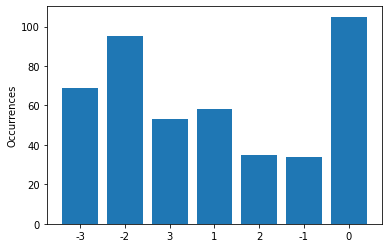

In [26]:
import numpy as np
import matplotlib.pyplot as plt

classes = {}
for t in data:
    classes[t.intensity] =  classes.get(t.intensity, 0) + 1

objects = classes.keys()
y_pos = np.arange(len(objects))
values = classes.values()

plt.bar(y_pos, values)
plt.xticks(y_pos, objects)
plt.ylabel('Occurrences')
plt.show()